## Function Definition

In [170]:
import numpy as np
import json
import graphviz
from IPython.display import display, Image

GLOBAL_SEED = 13520157
def linear(x):
    return x

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    if x.ndim == 2:
        x = x.T
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

## Class Definition

In [171]:
class FFNN:
    def __init__(self, n_neuron_each_layer=None, actfn=linear, preweight=None):
        if n_neuron_each_layer is None:
            n_neuron_each_layer = [1, 1]
        self.Wdict = {}
        n_layer = len(n_neuron_each_layer)
        assert n_layer >= 2 # minimum one for input and one for output
        assert callable(actfn)
        self.n_layer = n_layer
        self.n_neuron = n_neuron_each_layer
        self.actfn = actfn
        if preweight is None:
            for i in range(1, n_layer):
                np.random.seed(GLOBAL_SEED)
                self.Wdict[f'{i-1}-to-{i}'] = np.random.randn(n_neuron_each_layer[i-1]+1, n_neuron_each_layer[i])
                # print(f'{i-1}-to-{i}: {self.Wdict[f"{i-1}-to-{i}"].shape}')
        else:
            assert len(preweight) == n_layer - 1
            preweight = [np.array(w) for w in preweight]
            for i in range(1, n_layer):
                assert preweight[i-1].shape[0] == n_neuron_each_layer[i-1]+1
                assert preweight[i-1].shape[1] == n_neuron_each_layer[i]
                self.Wdict[f'{i-1}-to-{i}'] = preweight[i-1]
                # print(f'{i-1}-to-{i}: {self.Wdict[f"{i-1}-to-{i}"].shape}')

    def forward(self, data):
        assert data.ndim == 2
        assert data.shape[1] == self.n_neuron[0]
        # add bias
        data = np.hstack((np.ones((data.shape[0], 1)), data))
        for k, v in self.Wdict.items():
            data = self.actfn(data @ v)
            data = np.hstack((np.ones((data.shape[0], 1)), data))
        return data[:, 1:]

    def savetojson(self, filename):
        assert filename.endswith('.json')
        with open(filename, 'w') as f:
            data = {
                "n_neuron_each_layer": self.n_neuron,
                "actfn": self.actfn.__name__,
                "preweight": [v.tolist() for k, v in self.Wdict.items()]
            }
            json.dump(data, f)

    @staticmethod
    def loadfromjson(filename):
        assert filename.endswith('.json')
        with open(filename, 'r') as f:
            data = json.load(f)
            return FFNN(data['n_neuron_each_layer'], eval(data['actfn']), data['preweight'])

    def draw(self):
        graph = graphviz.Digraph()
        graph.attr(rankdir='LR')
        # Node
        for i in range(self.n_layer):
            if i != self.n_layer -1:
                graph.node(f'b_{i}', group=f'cluster_{i}', id=f"bias_{i}")
            for j in range(self.n_neuron[i]):
                graph.node(f'{i}_{j}', group=f'cluster_{i}')
        #Edges
        for layer in range(self.n_layer - 1):
            for cur_layer_i in range(-1, self.n_neuron[layer]):
                if cur_layer_i == -1:
                    src = f"b_{layer}"
                else:
                    src = f"{layer}_{cur_layer_i}"
                for next_layer_i in range(self.n_neuron[layer+1]):
                    tgt = f"{layer+1}_{next_layer_i}"
                    graph.edge(src, tgt)

        graph.format = 'png'
        display(Image(graph.render('FFNN Graph')))


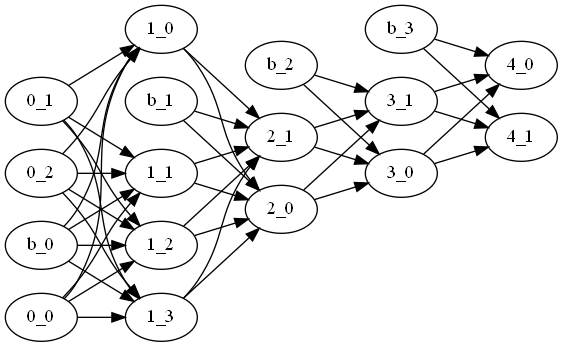

In [172]:
ff = FFNN([3, 4, 2, 2, 2], softmax)
np.random.seed(GLOBAL_SEED)
# print(ff.forward(np.random.randn(10, 4)))
ff.savetojson('test.json')
ff.draw()

In [173]:
ff2 = FFNN.loadfromjson('test.json')
np.random.seed(GLOBAL_SEED)
print(ff2.forward(np.random.randn(10, 4)))

AssertionError: 